In [2]:
import numpy as np
from scipy import optimize
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# 12 Popular
tickers = ["TSLA", "GOOGL", "META", "MSFT", "BCS", "LYG", "UL", "BP", "NSRGY", "AMZN", "DB", "XOM"]

data = yf.download(' '.join(tickers), period="5y", interval="1d", auto_adjust=True) # adjust for splits and dividends
data = data['Close'].ffill().bfill()
data.head()

[*********************100%***********************]  12 of 12 completed


Ticker,AMZN,BCS,BP,DB,GOOGL,LYG,META,MSFT,NSRGY,TSLA,UL,XOM
Date,,,,,,,,,,,,
2019-10-17 00:00:00+00:00,89.374001,6.983616,28.866491,7.283530,62.485275,2.547122,189.818466,133.424881,91.998665,17.464666,50.362537,53.262558
2019-10-18 00:00:00+00:00,87.875504,7.066953,28.652452,7.301970,62.066814,2.555419,185.292114,131.247147,91.543526,17.129999,50.446499,52.848278
2019-10-21 00:00:00+00:00,89.282997,7.100288,29.256388,7.449484,62.060329,2.596903,189.190369,132.221405,90.405685,16.900000,49.732800,53.731548
2019-10-22 00:00:00+00:00,88.286499,7.016951,29.439856,7.292750,61.906712,2.522232,181.792633,130.253799,90.388168,17.038668,49.682419,54.005135
2019-10-23 00:00:00+00:00,88.108498,7.108621,29.860315,7.366507,62.726181,2.530529,185.591202,131.084747,90.720779,16.978666,49.623642,54.521030


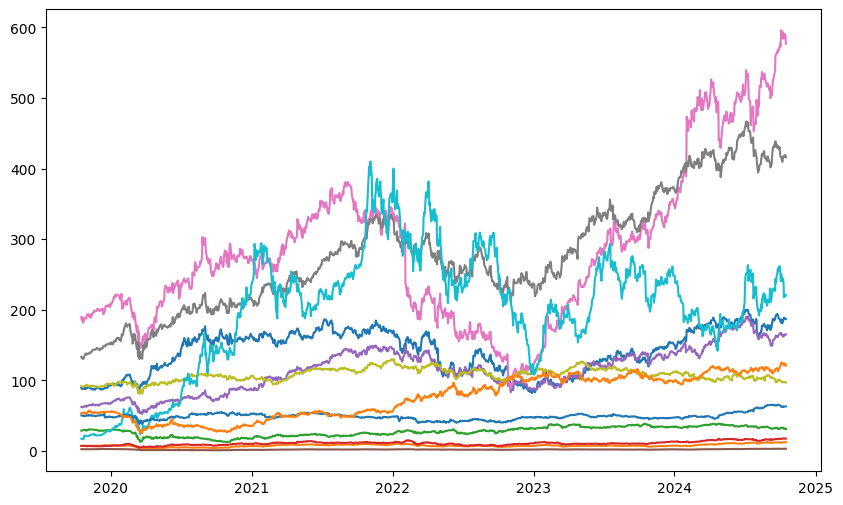

In [4]:
plt.figure(figsize=(10, 6))
fig1 = plt.plot(data)

In [5]:
amzn_data = yf.download("AMZN", period="5y", interval="1d", auto_adjust=True)
amzn_data['Daily Returns'] = np.log(amzn_data['Close'] / amzn_data['Close'].shift(1)).dropna()

[*********************100%***********************]  1 of 1 completed


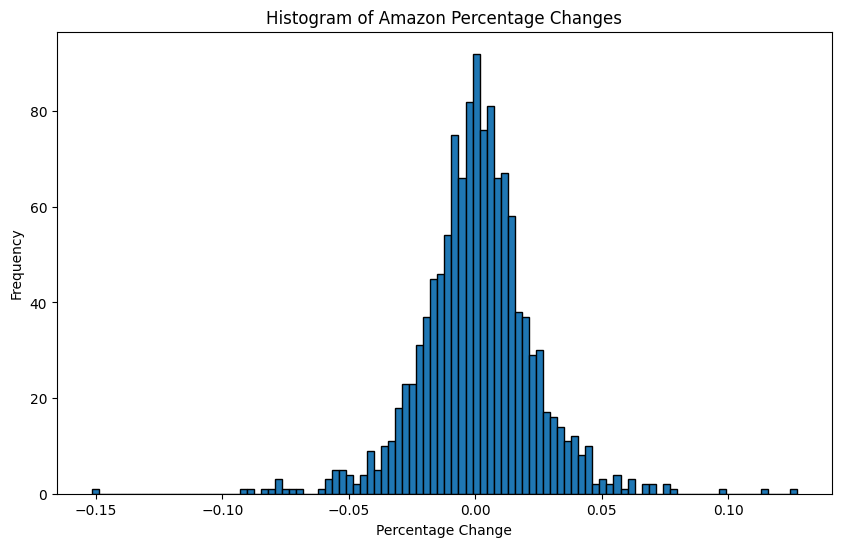

In [6]:
# Daily returns histogram looks normal, the same is assumed for the other assets
plt.figure(figsize=(10, 6))
plt.hist(amzn_data['Daily Returns'], bins=100, edgecolor='k')
plt.title('Histogram of Amazon Percentage Changes')
plt.xlabel('Percentage Change')
plt.ylabel('Frequency')
plt.show()

In [7]:
daily_log_returns = np.log(data / data.shift(1)).dropna() # https://quant.stackexchange.com/questions/1102/should-sharpe-ratio-be-computed-using-log-returns-or-relative-returns
print(daily_log_returns.head())

mean_daily_log_returns = daily_log_returns.mean()

Ticker                         AMZN       BCS        BP        DB     GOOGL  \
Date                                                                          
2019-10-18 00:00:00+00:00 -0.016909  0.011862 -0.007442  0.002528 -0.006719   
2019-10-21 00:00:00+00:00  0.015890  0.004706  0.020859  0.020001 -0.000104   
2019-10-22 00:00:00+00:00 -0.011224 -0.011807  0.006251 -0.021264 -0.002478   
2019-10-23 00:00:00+00:00 -0.002018  0.012979  0.014181  0.010063  0.013150   
2019-10-24 00:00:00+00:00  0.010506 -0.007059  0.003833 -0.011328  0.001176   

Ticker                          LYG      META      MSFT     NSRGY      TSLA  \
Date                                                                          
2019-10-18 00:00:00+00:00  0.003252 -0.024135 -0.016456 -0.004960 -0.019349   
2019-10-21 00:00:00+00:00  0.016103  0.020820  0.007396 -0.012507 -0.013518   
2019-10-22 00:00:00+00:00 -0.029175 -0.039887 -0.014993 -0.000194  0.008172   
2019-10-23 00:00:00+00:00  0.003284  0.020680  0.00

In [8]:
# Covariance Matrix of returns
cov_matrix_daily_returns = daily_log_returns.cov() # random variables (returns) are columns, observations are rows
print(cov_matrix_daily_returns.shape)

(12, 12)


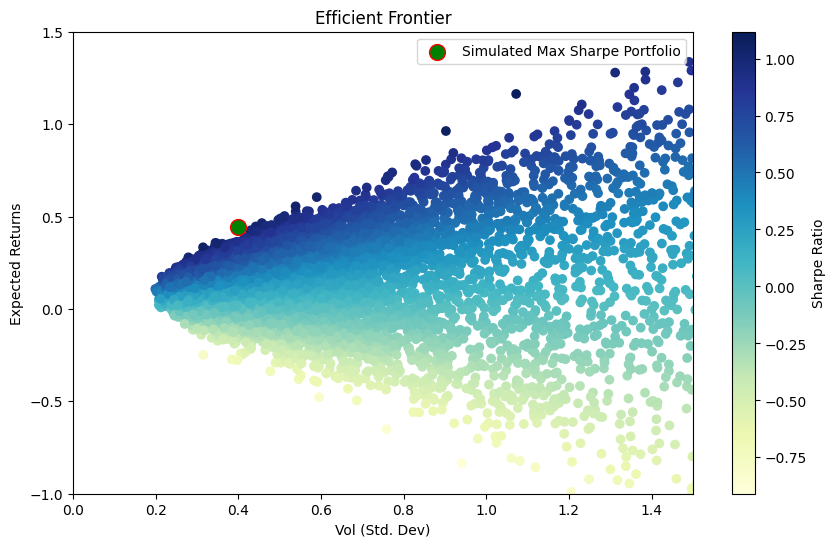

In [61]:
## Monte Carlo Simulation ##
# uses mathematics from https://www.casact.org/sites/default/files/database/astin_vol19s_9.pdf by HEINZ H. MULLER
num_portfolios = 10000
results = np.zeros((3, num_portfolios))
# results[0:i] = vol (std dev) of portfolio i
# results[1:i] = expected_return of portfolio i
# results[2:i] = sharpe_ratio of portfolio i
weights_record = []

for i in range(num_portfolios):

    # Generate a random vector from a normal distribution
    weights = np.random.uniform(-2, 2, len(tickers))
    # Normalize the vector to sum to 1
    weights /= np.sum(weights)
    # Debug
    #print(weights)
    #print("Sum of elements:", np.sum(weights))

    
    weights_record.append(weights)
    # vol (std dev)
    results[0,i] = np.sqrt(np.dot(weights.T, np.dot(cov_matrix_daily_returns * 252, weights))) # 252 trading days / year
    # expected return
    results[1,i] = np.dot(mean_daily_log_returns * 252, weights) # 252 trading days / year
    # sharpe
    results[2,i] = results[1,i] / results[0,i]

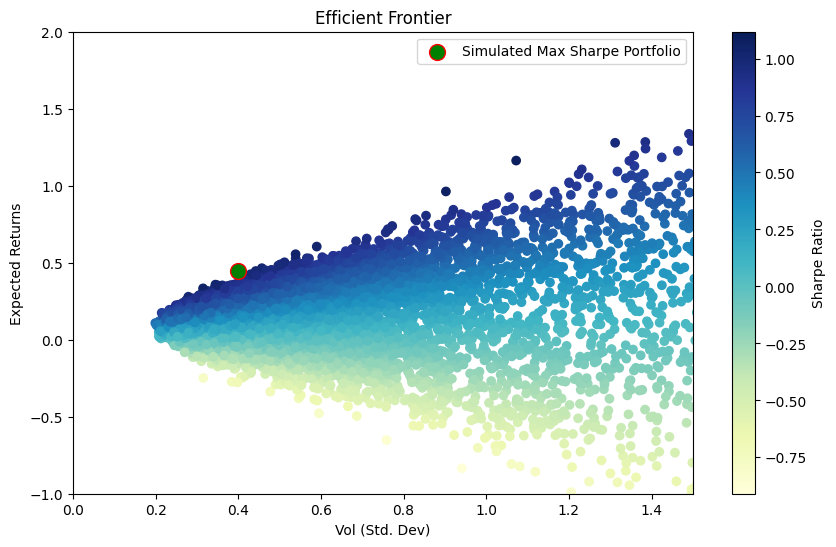

In [110]:
# Index of max Sharpe ratio
max_sharpe = results[2].max()
max_sharpe_index = results[2].argmax()
# Performance of max Sharpe ratio portfolio
max_sharpe_e_return = results[1][max_sharpe_index]
max_sharpe_e_vol = results[0][max_sharpe_index]

# Plotting the simulated frontier
plt.figure(figsize=(10, 6))
plt.scatter(results[0,:], results[1,:], c=results[2,:], cmap='YlGnBu', marker='o')
plt.title('Efficient Frontier')
plt.xlabel('Vol (Std. Dev)')
plt.ylabel('Expected Returns')
plt.colorbar(label='Sharpe Ratio')
# the max Sharpe portfolio
plt.scatter(max_sharpe_e_vol, max_sharpe_e_return, c='green', s=130, edgecolors='red', marker='o', label='Simulated Max \
Sharpe Portfolio')
plt.legend()
plt.ylim(-1,2)
plt.xlim(0,1.5)
plt.show()

In [62]:
# Simulation Summary
print('In the simulated best Sharpe portfolio with SR {}:'.format(max_sharpe))
for weight, stock in zip(weights_record[max_sharpe_index],tickers):
    print(f'{round(weight * 100, 2)} % of {stock} should be bought.')

max_sharpe_e_return_as_pct = max_sharpe_e_return * 100
max_sharpe_e_vol_as_pct = max_sharpe_e_vol * 100
# best portfolio return
print(f'\nExpected return is {round(max_sharpe_e_return_as_pct, 2)}% with volatility {round(max_sharpe_e_vol_as_pct,2)}%')
print(f'Thus the portfolio expected return will be within {round(max_sharpe_e_return_as_pct-max_sharpe_e_vol_as_pct, 2)}% to {round(max_sharpe_e_return_as_pct+max_sharpe_e_vol_as_pct, 2)}% 68% of the time')
print(f'and within {round(max_sharpe_e_return_as_pct-2*max_sharpe_e_vol_as_pct, 2)}% to {round(max_sharpe_e_return_as_pct+2*max_sharpe_e_vol_as_pct, 2)}% 95% of the time')

In the simulated best Sharpe portfolio with SR 1.1175891207027235:
-31.71 % of TSLA should be bought.
-22.88 % of GOOGL should be bought.
-51.76 % of META should be bought.
17.05 % of MSFT should be bought.
44.34 % of BCS should be bought.
-12.65 % of LYG should be bought.
25.03 % of UL should be bought.
42.95 % of BP should be bought.
6.21 % of NSRGY should be bought.
31.78 % of AMZN should be bought.
-12.04 % of DB should be bought.
63.7 % of XOM should be bought.

Expected return is 44.52% with volatility 39.83%
Thus the portfolio expected return will be within 4.68% to 84.35% 68% of the time
and within -35.15% to 124.18% 95% of the time


In [63]:
# Using scipy optimize for a best sharpe portfolio solution
guess = np.full(shape=len(tickers), fill_value=1 / len(tickers))

def portfolio_performance(weights):
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix_daily_returns * 252, weights))) # 252 trading days / year
    exp_ret = np.dot(mean_daily_log_returns * 252, weights) # 252 trading days / year
    sharpe = exp_ret/vol
    return vol, exp_ret, sharpe # scipy minimize will maximize the sharpe

def get_portfolio_variance(weights):
    return np.dot(weights.T, np.dot(cov_matrix_daily_returns * 252, weights))

def get_portfolio_std_dev(weights):
    return portfolio_performance(weights)[0]

def get_negative_sr(weights):
    vol, ret, sr = portfolio_performance(weights)
    return sr * -1

def check_sum(weights):
    return np.sum(weights) - 1
constraint_dict = {'type':'eq','fun':check_sum}
no_short_selling = [(0, 1) for _ in range(len(tickers))] # no short selling
optimization_results = optimize.minimize(fun=get_negative_sr, x0=guess, method="SLSQP", constraints=[constraint_dict], bounds=no_short_selling)

In [64]:
# Optimal weights (no short selling)
optimal_weights = optimization_results.x
optimal_std_dev = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix_daily_returns * 252, optimal_weights))) # 252 trading days / year
optimal_exp_ret = np.dot(mean_daily_log_returns * 252, optimal_weights) # 252 trading days / year
optimal_sharpe = optimal_exp_ret/optimal_std_dev

print('In the optimal Sharpe portfolio (no shorts) with SR {}:'.format(optimal_sharpe))
for st, i in zip(tickers,optimal_weights):
    print(f'Stock {st} has weight {np.round(i*100,2)} %')
print()


optimal_e_return_as_pct = optimal_exp_ret * 100
optimal_vol_as_pct = optimal_std_dev * 100
# best portfolio return
print(f'\nExpected return is {round(optimal_e_return_as_pct, 2)}% with volatility {round(optimal_vol_as_pct,2)}%')
print(f'Thus the portfolio expected return will be within {round(optimal_e_return_as_pct-optimal_vol_as_pct, 2)}% to {round(optimal_e_return_as_pct+optimal_vol_as_pct, 2)}% 68% of the time')
print(f'and within {round(optimal_e_return_as_pct-2*optimal_vol_as_pct, 2)}% to {round(optimal_e_return_as_pct+2*optimal_vol_as_pct, 2)}% 95% of the time')

In the optimal Sharpe portfolio (no shorts) with SR 0.9334640899764791:
Stock TSLA has weight 0.0 %
Stock GOOGL has weight 0.0 %
Stock META has weight 0.0 %
Stock MSFT has weight 0.0 %
Stock BCS has weight 0.0 %
Stock LYG has weight 0.0 %
Stock UL has weight 0.09 %
Stock BP has weight 47.09 %
Stock NSRGY has weight 0.0 %
Stock AMZN has weight 25.98 %
Stock DB has weight 0.0 %
Stock XOM has weight 26.85 %


Expected return is 28.38% with volatility 30.41%
Thus the portfolio expected return will be within -2.02% to 58.79% 68% of the time
and within -32.43% to 89.2% 95% of the time


In [65]:
# Optimal weights (with short selling)
short_optimization_results = optimize.minimize(fun=get_negative_sr, x0=guess, method="SLSQP", constraints=[constraint_dict])
short_optimal_weights = short_optimization_results.x
short_optimal_std_dev = np.sqrt(np.dot(short_optimal_weights.T, np.dot(cov_matrix_daily_returns * 252, short_optimal_weights))) # 252 trading days / year
short_optimal_exp_ret = np.dot(mean_daily_log_returns * 252, short_optimal_weights) # 252 trading days / year
short_optimal_sharpe = short_optimal_exp_ret/short_optimal_std_dev

print('In the optimal Sharpe portfolio (with shorts) with SR {}:'.format(short_optimal_sharpe))
for st, i in zip(tickers,short_optimal_weights):
    print(f'Stock {st} has weight {np.round(i*100,2)} %')
print()


short_optimal_e_return_as_pct = short_optimal_exp_ret * 100
short_optimal_vol_as_pct = short_optimal_std_dev * 100
# best portfolio return
print(f'\nExpected return is {round(short_optimal_e_return_as_pct, 2)}% with volatility {round(short_optimal_vol_as_pct,2)}%')
print(f'Thus the portfolio expected return will be within {round(short_optimal_e_return_as_pct-short_optimal_vol_as_pct, 2)}% to {round(optimal_e_return_as_pct+optimal_vol_as_pct, 2)}% 68% of the time')
print(f'and within {round(short_optimal_e_return_as_pct-2*short_optimal_vol_as_pct, 2)}% to {round(short_optimal_e_return_as_pct+2*short_optimal_vol_as_pct, 2)}% 95% of the time')

In the optimal Sharpe portfolio (with shorts) with SR 1.3276214528905734:
Stock TSLA has weight -80.91 %
Stock GOOGL has weight 40.39 %
Stock META has weight -211.56 %
Stock MSFT has weight 64.81 %
Stock BCS has weight 17.91 %
Stock LYG has weight -96.79 %
Stock UL has weight 16.35 %
Stock BP has weight 158.53 %
Stock NSRGY has weight -112.77 %
Stock AMZN has weight 63.28 %
Stock DB has weight 13.42 %
Stock XOM has weight 227.34 %


Expected return is 109.3% with volatility 82.32%
Thus the portfolio expected return will be within 26.97% to 58.79% 68% of the time
and within -55.35% to 273.95% 95% of the time


In [75]:
# Finding the Global Minimum Variance portfolio
# using https://bookdown.org/compfinezbook/introcompfinr/Determining-the-Global.html#eq:PortMatrixGlobalMinFOC1

yearly_cov_matrix = cov_matrix_daily_returns * 252
n = yearly_cov_matrix.shape[0]

# Create the matrix A
# (2 * Σ  1) 
# (1'     0)
# and vector B
# (n*0)
# (1)
top = np.hstack((2 * yearly_cov_matrix, np.ones((n, 1))))
bottom = np.hstack((np.ones((1, n)), np.zeros((1, 1))))
matrix_a = np.vstack((top, bottom))
vector_b = np.vstack((np.zeros((n,1)), np.ones((1,1))))
# solution weights are the first n elements of the vector z = (A)^-1 * b
vector_z = np.linalg.inv(matrix_a) @ vector_b
gmv_weights = vector_z[:n].flatten()

# characteristics of global minimum variance portfolio
gmv_std_dev = np.sqrt(np.dot(gmv_weights.T, np.dot(cov_matrix_daily_returns * 252, gmv_weights))) # 252 trading days / year
gmv_exp_ret = np.dot(mean_daily_log_returns * 252, gmv_weights) # 252 trading days / year
gmv_sharpe = gmv_exp_ret/gmv_std_dev

print('The Global Minimum Variance portfolio has volatility {}% and SR {}'.format(round(gmv_std_dev * 100, 2), gmv_sharpe))

The Global Minimum Variance portfolio has volatility 16.77% and SR 0.27036680046818107


In [111]:
# Finding the Efficient Frontier curve

# possible expected return values
# results[1:i] = expected_return of portfolio i
# frontier_ret = np.linspace(results[1].min(), results[1].max(), 50)
frontier_ret = np.linspace(-1, 2, 100) # will optimize portfolios with returns ranging from -50% to 100%, hardcoding as the max and min of the monte carlo portfolios can be extreme
frontier_vol = []
# frontier_weights = []
# frontier_solved = []

for ret_constraint in frontier_ret:
    # solving for the weights that give a return equal to a given return
    cons = ({'type':'eq','fun':check_sum},
            {'type':'eq','fun':lambda weights: portfolio_performance(weights)[1] - ret_constraint})
    optimization_results = optimize.minimize(fun=get_portfolio_std_dev, x0=guess, method="SLSQP", constraints=cons)
    frontier_vol.append(optimization_results['fun'])
    # frontier_weights.append(optimization_results.x)
    # frontier_solved.append(optimization_results.success) # to check if a portfolio meeting the return constraint was even possible

In [121]:
# Introducing a risk-free rate (govt bond) and computing the tangency portfolio

# math from https://bookdown.org/compfinezbook/introcompfinr/Efficient-portfolios-of.html

yearly_risk_free_rate = 0.035 # 3.5% bond yield

ones_col = np.ones((len(tickers), 1)).flatten()
yearly_returns_minus_risk_free_vec = mean_daily_log_returns * 252 - yearly_risk_free_rate * ones_col

# numerator
numerator = np.linalg.inv(yearly_cov_matrix) @ (mean_daily_log_returns * 252 - yearly_risk_free_rate * ones_col)
# denominator
denom = (ones_col.T @ yearly_cov_matrix) @ (mean_daily_log_returns * 252 - yearly_risk_free_rate * ones_col)
tangency_weights = numerator/denom

# characteristics of tangency portfolio given risk free rate
tangency_std_dev = np.sqrt(np.dot(tangency_weights.T, np.dot(cov_matrix_daily_returns * 252, tangency_weights))) # 252 trading days / year
tangency_exp_ret = np.dot(mean_daily_log_returns * 252, tangency_weights) # 252 trading days / year
tangency_sharpe = tangency_exp_ret/tangency_std_dev

tangency_e_return_as_pct = tangency_exp_ret * 100
tangency_vol_as_pct = tangency_std_dev * 100
# best portfolio return
print('For tangency portfolio with risk free rate = {}'.format(yearly_risk_free_rate))
print(f'\nExpected return is {round(tangency_e_return_as_pct, 2)}% with volatility {round(tangency_vol_as_pct,2)}% and sharpe {tangency_sharpe}')
print('Compare with Sharpe of optimal risky portfolio (including shorts) of {}'.format(short_optimal_sharpe))

# for graphing
cml_x = [0, tangency_std_dev * 5]
cml_y = [yearly_risk_free_rate, tangency_exp_ret * 5]

For tangency portfolio with risk free rate = 0.035

Expected return is 131.03% with volatility 99.94% and sharpe 1.3111487296327315
Compare with Sharpe of optimal risky portfolio (including shorts) of 1.3276214528905734


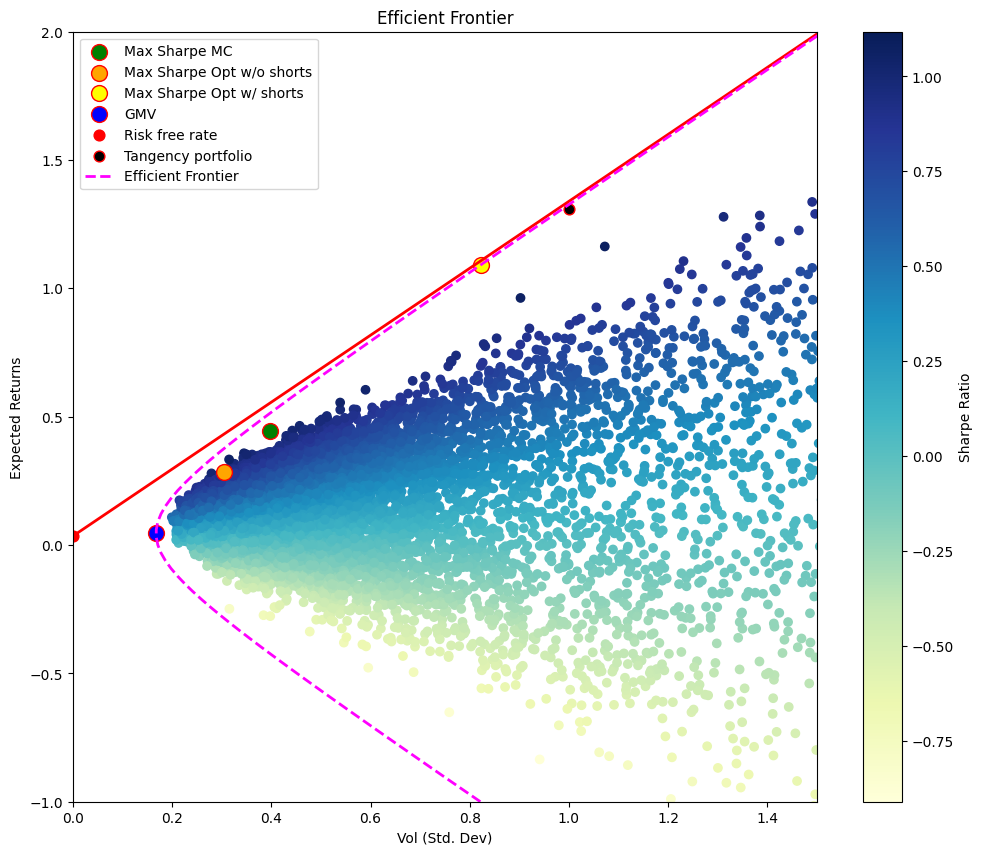

In [119]:
# Plotting the efficient frontier and everything else
plt.figure(figsize=(12, 10))
plt.scatter(results[0,:], results[1,:], c=results[2,:], cmap='YlGnBu', marker='o')
plt.title('Efficient Frontier')
plt.xlabel('Vol (Std. Dev)')
plt.ylabel('Expected Returns')
plt.colorbar(label='Sharpe Ratio')
# Monte Carlo best Sharpe portfolio (no shorts)
plt.scatter(max_sharpe_e_vol, max_sharpe_e_return, c='green', s=130, edgecolors='red', marker='o', label='Max Sharpe MC')
# Optimized Sharpe portfolio (no shorts)
plt.scatter(optimal_std_dev, optimal_exp_ret, c='orange', s=130, edgecolors='red', marker='o', label='Max Sharpe Opt w/o shorts')
# Optimized Sharpe portfolio (with shorts)
plt.scatter(short_optimal_std_dev, short_optimal_exp_ret, c='yellow', s=130, edgecolors='red', marker='o', label='Max Sharpe Opt w/ shorts')
# GMV portfolio
plt.scatter(gmv_std_dev, gmv_exp_ret, c='blue', s=130, edgecolors='red', marker='o', label='GMV')
# Risk Free Rate
plt.scatter(0, yearly_risk_free_rate, c='red', s=60, edgecolors='red', marker='o', label='Risk free rate')
# Tangency portfolio given risk free rate
plt.scatter(tangency_std_dev, tangency_exp_ret, c='black', s=60, edgecolors='red', marker='o', label='Tangency portfolio')
# Capital Market Line (CML)
plt.plot(cml_x, cml_y, color='red', linestyle='-', linewidth=2)
# Frontier line
plt.plot(frontier_vol, frontier_ret, c='magenta', linestyle='--', linewidth=2, label='Efficient Frontier')
plt.legend()
plt.ylim(-1,2)
plt.xlim(0,1.5)
plt.show()